# Activations, Gradients, BatchNorm

[Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc)

| Date | User | Change Type | Remarks |  
| ---- | ---- | ----------- | ------- |
| 21/10/2025   | Martin | Create   | Notebook created for lecture 3 | 
| 22/10/2025   | Martin | Update   | Completed batch norm and analysis of initialisation and hyperparameters for learning stability | 

# Content

* [Original Model](#original-model)
* [Problems with the Original Model](#problems-with-the-original-model)
* [Selecting Initialisation Parameters](#selecting-initialisation-parameters)
* [Batch Normalisation](#batch-normalisation)

# Original Model

In [1]:
%load_ext watermark

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [6]:
# Read in all the words
words = open('data/names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [7]:
# Build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
stoi = {v: k+1 for k, v in enumerate(chars)}
stoi['.'] = 0
itos = {v: k for k, v in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [8]:
def build_dataset(words):
  block_size = 3
  X, Y = [], []
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix]
    
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)

  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, y_train = build_dataset(words[:n1])
X_val, y_val = build_dataset(words[n1:n2])
X_test, y_test = build_dataset(words[n2:])

block_size = 3

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [10]:
# Initialise weights and biases
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) # represents the weights of each letter
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g)
b1 = torch.randn(n_hidden, generator=g)
W2 = torch.randn((n_hidden, vocab_size), generator=g)
b2 = torch.randn(vocab_size, generator=g)

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 11897


In [ ]:
# Model
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  X_batch, y_batch = X_train[ix], y_train[ix]

  # forward pass
  emb = C[X_batch]
  h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y_batch)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # Track stats
  if i % 10_000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 25.5262
  10000/ 200000: 1.8764
  20000/ 200000: 2.2232
  30000/ 200000: 2.4598
  40000/ 200000: 2.7547
  50000/ 200000: 2.0915
  60000/ 200000: 2.7164
  70000/ 200000: 2.5265
  80000/ 200000: 2.0639
  90000/ 200000: 2.5379
 100000/ 200000: 2.3101
 110000/ 200000: 2.2106
 120000/ 200000: 2.0415
 130000/ 200000: 1.7847
 140000/ 200000: 2.5636
 150000/ 200000: 2.2658
 160000/ 200000: 2.0577
 170000/ 200000: 2.1290
 180000/ 200000: 2.5550
 190000/ 200000: 1.8188


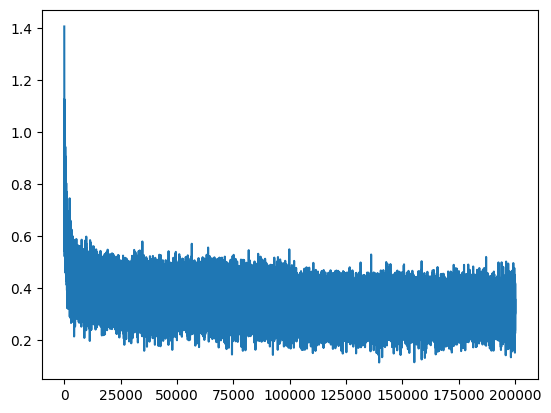

In [12]:
plt.plot(lossi)

In [13]:
# For evaluation
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test)
  }[split]

  emb = C[x]
  h = torch.tanh(emb.view(emb.shape[0], -1) @ W1 + b1)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.122971773147583
val 2.1836750507354736


In [14]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
  out = []
  context = [0] * block_size
  while True:
    emb = C[torch.tensor([context])]
    h = torch.tanh(emb.view(1, -1) @ W1 + b1)
    logits = h @ W2 + b2
    probs = F.softmax(logits, dim=1)
    ix = torch.multinomial(probs, num_samples=1, generator=g).item()
    context = context[1:] + [ix]
    out.append(ix)
    if ix == 0:
      break
  
  print(''.join(itos[i] for i in out))

carmahzati.
hari.
kimleigentleenandell.
mahnen.
den.
art.
kaeli.
nellara.
chriiv.
kaleigh.
ham.
joce.
quint.
suline.
liven.
corathoniearyni.
jaxeephurabeed.
edi.
abette.
hasti.


---

# Problems with The Original Model

## Initial weight and initialisation loss

- Often we would have __an idea of what the initial loss__ should look like
- Initialisation loss is too high (25+), expected uniform distribution since likelihood of all chracters are the same
  - Happens because the `softmax` is assigning very wide distribution which causes the loss to be off
  - Goal is to make a uniform distribution with some __small__ variation in the weights

In [ ]:
# Expected value
-torch.tensor(1/27.0).log()

tensor(3.2958)

In [ ]:
# Example of smaller weights
torch.randn((n_hidden, vocab_size), generator=g) * 0.1 # Reducing the difference between each vale # Reducing the difference between each vale # Reducing the difference between each vale # Reducing the difference between each value

tensor([[-0.0373, -0.0871, -0.0486,  ..., -0.0201,  0.1541, -0.2888],
        [-0.0205,  0.1022, -0.0046,  ...,  0.0999, -0.1100, -0.0731],
        [ 0.0339,  0.1234, -0.0389,  ..., -0.0337,  0.0246,  0.1154],
        ...,
        [ 0.1002,  0.0396, -0.1016,  ..., -0.0548,  0.0164,  0.0033],
        [ 0.0115, -0.0723, -0.0072,  ..., -0.0987,  0.0468, -0.0479],
        [ 0.1195, -0.1391,  0.1748,  ...,  0.1166,  0.1666,  0.2088]])

In [45]:
# Initialise weights and biases
n_embd = 10
n_hidden = 200

# Fixing the problems below
g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) 
W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * 0.2
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 11897


In [50]:
# Model
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  X_batch, y_batch = X_train[ix], y_train[ix]

  # forward pass
  emb = C[X_batch]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y_batch)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # Track stats
  if i % 10_000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.2456
  10000/ 200000: 2.2303
  20000/ 200000: 2.0571
  30000/ 200000: 2.3195
  40000/ 200000: 2.0922
  50000/ 200000: 1.9866
  60000/ 200000: 1.8602
  70000/ 200000: 2.3677
  80000/ 200000: 2.3242
  90000/ 200000: 2.5517
 100000/ 200000: 2.1420
 110000/ 200000: 1.7095
 120000/ 200000: 2.0184
 130000/ 200000: 2.0786
 140000/ 200000: 1.9988
 150000/ 200000: 2.0864
 160000/ 200000: 1.7745
 170000/ 200000: 1.8406
 180000/ 200000: 2.0670
 190000/ 200000: 1.9148


Model has more time spent optimising the weights since the initial rounds of the training sequence no longer needs to squash the weight value

In [27]:
split_loss('train')
split_loss('val')

train 2.064987897872925
val 2.1448941230773926


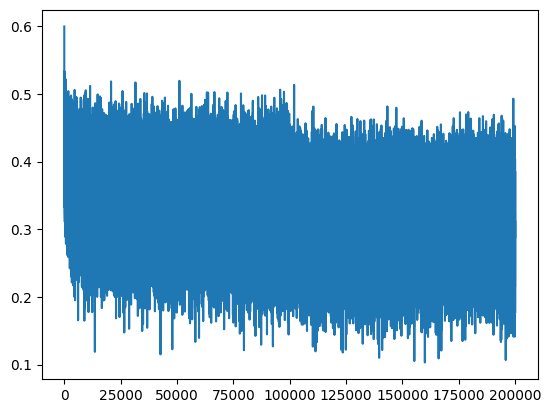

In [29]:
plt.plot(lossi)

## Tanh and gradients

- Tanh function forces values to be within -1 and 1. Because the original distribution of weights are wide, it forces many values of `tanh` to be at the extreme ends
- Causes the vanishing gradient problem (i.e if any of the columns in the white and black box plot are all white), causes dead neurons since gradients are not updating any values
- 📜 NOTE: This happens when the activation functions have flat regions

(array([2143.,  141.,   99.,   68.,   62.,   46.,   20.,   54.,   29.,
          33.,   23.,   18.,   28.,   36.,   15.,   22.,   26.,   28.,
          17.,   24.,   13.,   29.,   18.,   14.,   19.,   15.,   15.,
          12.,   13.,   12.,   15.,   32.,   20.,   19.,   16.,   21.,
          29.,   19.,   33.,   34.,   32.,   29.,   42.,   53.,   45.,
          52.,   65.,   86.,  147., 2519.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

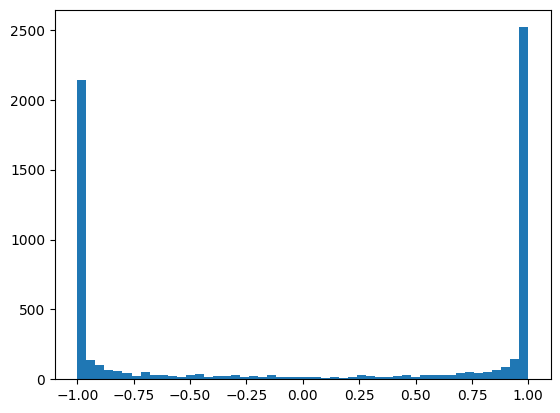

In [31]:
# Plot the intermediate node values as a histogram
plt.hist(h.view(-1).tolist(), 50)

(array([  2.,   5.,   4.,   5.,   6.,  12.,  10.,  17.,  24.,  47.,  46.,
         80., 111., 148., 166., 200., 267., 307., 334., 343., 427., 472.,
        470., 398., 364., 340., 319., 315., 255., 216., 175., 122., 113.,
         78.,  59.,  49.,  27.,  22.,  23.,   5.,  10.,   2.,   1.,   1.,
          1.,   0.,   1.,   0.,   0.,   1.]),
 array([-2.20257263e+01, -2.10235646e+01, -2.00214030e+01, -1.90192413e+01,
        -1.80170796e+01, -1.70149179e+01, -1.60127563e+01, -1.50105946e+01,
        -1.40084329e+01, -1.30062712e+01, -1.20041096e+01, -1.10019479e+01,
        -9.99978622e+00, -8.99762455e+00, -7.99546288e+00, -6.99330120e+00,
        -5.99113953e+00, -4.98897785e+00, -3.98681618e+00, -2.98465450e+00,
        -1.98249283e+00, -9.80331154e-01,  2.18305206e-02,  1.02399220e+00,
         2.02615387e+00,  3.02831554e+00,  4.03047722e+00,  5.03263889e+00,
         6.03480057e+00,  7.03696224e+00,  8.03912392e+00,  9.04128559e+00,
         1.00434473e+01,  1.10456089e+01,  1.20477

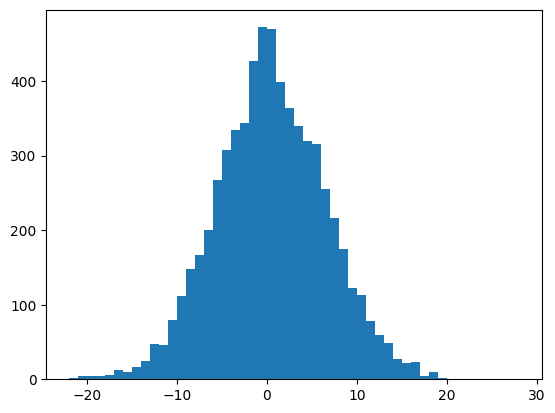

In [32]:
plt.hist(hpreact.view(-1).tolist(), 50)

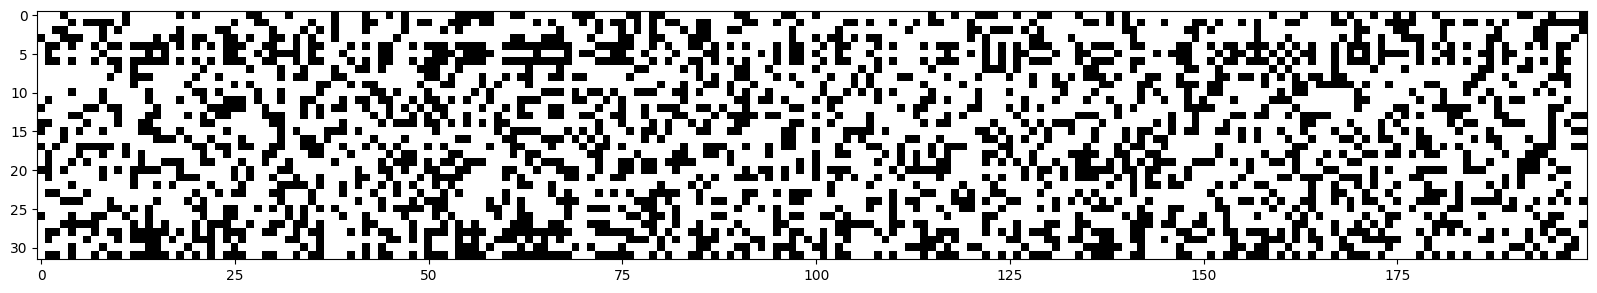

In [38]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

Replotting with the updated initialisations

(array([1059.,  200.,  139.,  113.,   93.,   84.,   69.,   66.,   55.,
          58.,   51.,   54.,   55.,   60.,   70.,   60.,   63.,   50.,
          64.,   97.,   85.,  128.,  100.,  170.,  116.,  108.,   76.,
          96.,   92.,  105.,   84.,   87.,   90.,   63.,   44.,   74.,
          63.,   69.,   62.,   72.,   59.,   60.,   75.,   66.,   89.,
         107.,   95.,  130.,  230., 1145.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

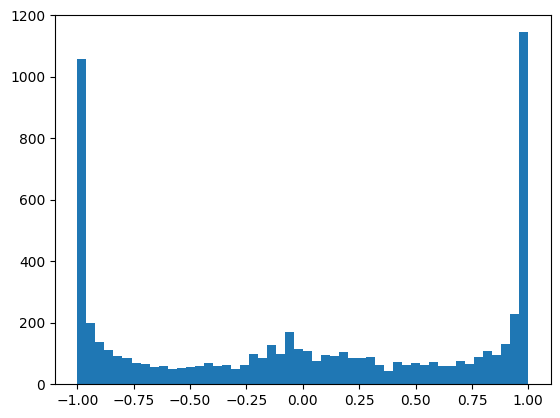

In [51]:
plt.hist(h.view(-1).tolist(), 50)

(array([  1.,   1.,   1.,   3.,   5.,   4.,   7.,  10.,  11.,  19.,  31.,
         49.,  58.,  64.,  92., 109., 119., 180., 200., 199., 234., 285.,
        309., 458., 990., 668., 395., 321., 225., 244., 231., 188., 142.,
        127.,  88.,  78.,  67.,  43.,  41.,  30.,  25.,  11.,  14.,   8.,
          7.,   2.,   2.,   2.,   1.,   1.]),
 array([-9.24822712, -8.87346127, -8.49869541, -8.12392956, -7.7491637 ,
        -7.37439785, -6.999632  , -6.62486614, -6.25010029, -5.87533443,
        -5.50056858, -5.12580273, -4.75103687, -4.37627102, -4.00150517,
        -3.62673931, -3.25197346, -2.8772076 , -2.50244175, -2.1276759 ,
        -1.75291004, -1.37814419, -1.00337833, -0.62861248, -0.25384663,
         0.12091923,  0.49568508,  0.87045094,  1.24521679,  1.61998264,
         1.9947485 ,  2.36951435,  2.7442802 ,  3.11904606,  3.49381191,
         3.86857777,  4.24334362,  4.61810947,  4.99287533,  5.36764118,
         5.74240704,  6.11717289,  6.49193874,  6.8667046 ,  7.24147045,
 

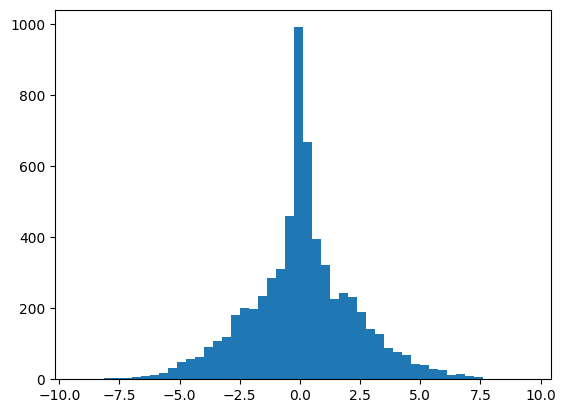

In [52]:
plt.hist(hpreact.view(-1).tolist(), 50)

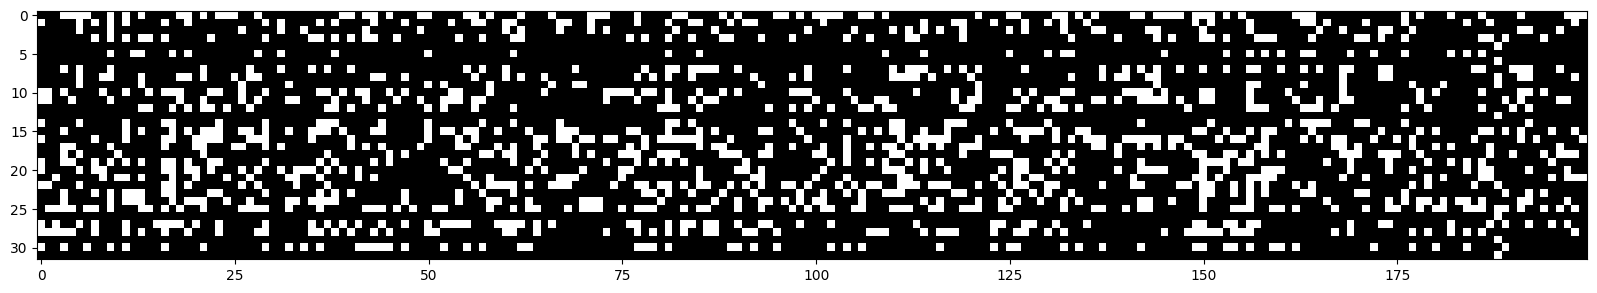

In [53]:
plt.figure(figsize=(20, 10))
plt.imshow(h.abs() > 0.99, cmap='gray', interpolation='nearest')

---

# Selecting Initialisation Parameters

- Want to reduce the standard deviation s.t the weights are initialised within the range used by the activation function that prevents the vanishing gradient problem
- He Initialisation (`kaiming_...`) prevents the vanishing gradient problem
  - [Paper](https://arxiv.org/abs/1502.01852)
  - [PyTorch Initialisation Docs](https://docs.pytorch.org/docs/stable/nn.init.html)
- 📜 NOTE: He Initialisation (ReLU) | Xavier/ Glorot Initialisation (Sigmoid & Tanh)

tensor(-0.0123) tensor(0.9987)
tensor(0.0007) tensor(0.9971)


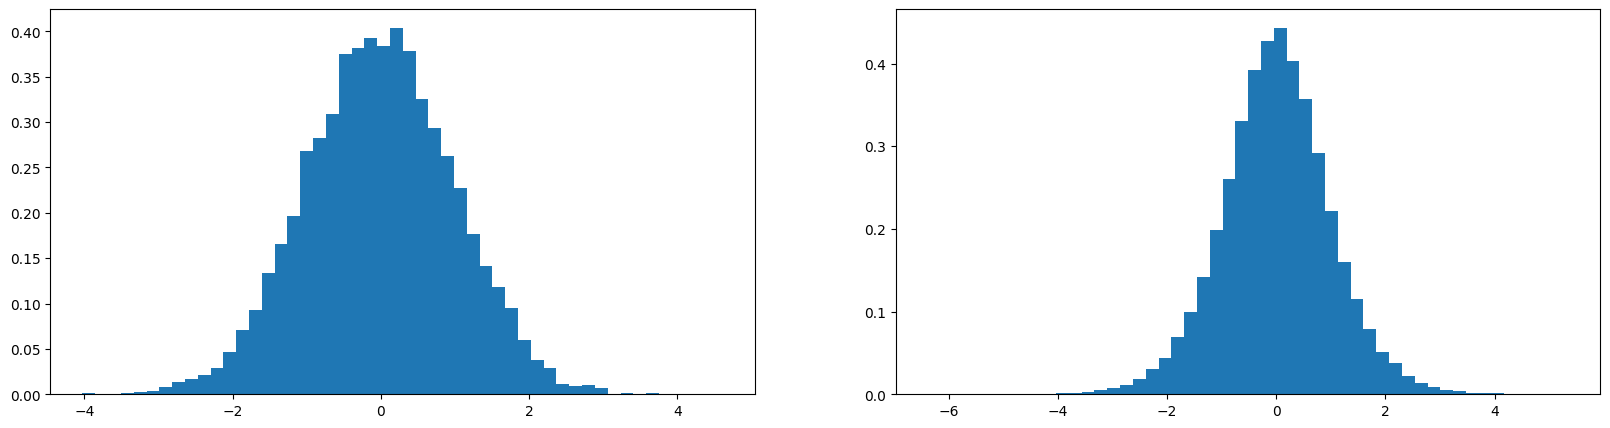

In [68]:
# Impact of normalisation
x = torch.randn(1000, 10)
w = torch.randn(10, 200) / 10**0.5 # here added normalisation factor
y = x @ w
print(x.mean(), x.std())
print(y.mean(), y.std())
plt.figure(figsize=(20, 5))
plt.subplot(121)
plt.hist(x.view(-1).tolist(), 50, density=True)
plt.subplot(122)
plt.hist(y.view(-1).tolist(), 50, density=True)
plt.show()

In [56]:
# Kaiming initialisation - manual is taken by the formula in the paper
W1_kaiming_manual = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5)
W1_kaiming_manual.std()

tensor(0.3025)

In [64]:
torch.nn.init.kaiming_normal_(torch.randn((n_embd * block_size, n_hidden))).std()

tensor(0.1003)

---

# Batch Normalisation

- Batch normalisation "fixes" the initialisation problem described earlier because it forces all weights to be within that fixed range
- It also couples the normalisation to the randomly selected batch, which introduces some regularisation improving model performance
  - But this is sort of undesireable because the coupling effect makes it somewhat unstable
- Batch Normalisation also removes the bias term on any weights before it's applied

<u>Note of PyTorch Implementation</u>

- `momentum`: How much of the current batch's mean and standard deviation is being carried over to the global value. Smaller batch size should have smaller momentum. 
- `affine`: Tracks the global running values for use in evaluation

<u>Alternatives</u>

1. Group Normalisation
2. Layer Normalisation

In [ ]:
# Normalising the weights before passing to activation
hpreact = embcat @ W1 + b1
hpreact_norm = (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True)

In [79]:
# Initialise weights and biases
n_embd = 10
n_hidden = 200

g = torch.Generator().manual_seed(2147483647)
C = torch.randn((vocab_size, n_embd), generator=g) 
# W1 = torch.randn((n_embd * block_size, n_hidden), generator=g) * (5/3)/((n_embd * block_size) ** 0.5)
W1 = torch.nn.init.kaiming_normal_(torch.randn((n_embd * block_size, n_hidden), generator=g))
b1 = torch.randn(n_hidden, generator=g) * 0.01
W2 = torch.randn((n_hidden, vocab_size), generator=g) * 0.01
b2 = torch.randn(vocab_size, generator=g) * 0

# Introduce batch normalisation scale and shift parameters
bngain = torch.ones((1, n_hidden))
bnbias = torch.ones((1, n_hidden))
bnmean_running = torch.ones((1, n_hidden))
bnstd_running = torch.ones((1, n_hidden))

parameters = [C, W1, b1, W2, b2, bngain, bnbias]
for p in parameters:
  p.requires_grad = True

print(f"Total number of parameters: {sum(p.nelement() for p in parameters)}")

Total number of parameters: 12297


In [80]:
# Model
max_steps = 200_000
batch_size = 32
lossi = []

for i in range(max_steps):
  # minibatch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  X_batch, y_batch = X_train[ix], y_train[ix]

  # forward pass
  emb = C[X_batch]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 # Bias was removed
  bnmeani = hpreact.mean(0, keepdim=True)
  bnstdi = hpreact.std(0, keepdim=True)

  # Store the current iterations batchnorm mean and std
  with torch.no_grad():
    bnmean_running = 0.999 * bnmean_running + 0.001 * bnmeani
    bnstd_running = 0.999 * bnstd_running + 0.001 * bnstdi

  hpreact = bngain * (hpreact - bnmeani) / bnstdi + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y_batch)

  # backward pass
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # Track stats
  if i % 10_000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())

      0/ 200000: 3.3005
  10000/ 200000: 1.7496
  20000/ 200000: 1.8934
  30000/ 200000: 2.4658
  40000/ 200000: 2.3857
  50000/ 200000: 1.9055
  60000/ 200000: 2.3602
  70000/ 200000: 2.1367
  80000/ 200000: 1.7882
  90000/ 200000: 2.3494
 100000/ 200000: 2.1532
 110000/ 200000: 2.1854
 120000/ 200000: 2.0060
 130000/ 200000: 1.7909
 140000/ 200000: 2.2147
 150000/ 200000: 2.2042
 160000/ 200000: 1.8786
 170000/ 200000: 2.1622
 180000/ 200000: 2.5828
 190000/ 200000: 1.8593


In [83]:
# During prediction, a global mean and standard deviation is calculated for single data points
with torch.no_grad():
  emb = C[X_train]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  bnmean_global = hpreact.mean(0, keepdim=True)
  bnstd_global = hpreact.std(0, keepdim=True)

In [84]:
bnmean_global

tensor([[-1.2612e-01, -1.0051e-01, -2.1702e+00,  2.4372e-01,  1.4944e+00,
         -2.9264e-01,  1.6703e+00, -5.5624e-01, -9.5669e-01,  1.1853e+00,
          1.3675e+00,  4.9302e-01, -4.3049e-01,  2.3561e-01, -1.0605e+00,
          2.8803e-01,  3.0179e-01, -6.4920e-01, -9.3474e-01,  1.4905e+00,
         -2.8807e-01, -4.1343e-03,  2.1199e-01,  4.5573e-01, -1.4325e+00,
          1.7215e+00,  1.8111e+00, -1.9293e-01, -6.7330e-01,  4.8783e-01,
         -7.2574e-01,  7.4501e-01,  1.5750e+00,  8.6376e-01,  8.5215e-01,
         -8.7254e-01, -2.0355e-03, -1.1334e+00,  7.2321e-01, -9.4734e-01,
         -1.0217e+00, -8.9400e-01,  2.7695e+00, -2.5688e+00, -9.4486e-01,
          7.4543e-01, -8.7580e-01,  1.7594e+00, -1.0670e+00, -2.1044e+00,
          8.8767e-01, -2.7694e-01, -7.7919e-02,  6.5699e-01, -4.1172e-01,
          2.7234e-01, -1.8186e+00,  4.7657e-01,  1.1556e+00,  5.1692e-02,
          5.6194e-01, -1.6503e-01,  4.5875e-01, -1.0336e+00, -5.8156e-01,
          9.1765e-01, -4.0816e-01,  7.

In [82]:
bnmean_running

tensor([[-0.1342, -0.1015, -2.1609,  0.2505,  1.4949, -0.2887,  1.6693, -0.5581,
         -0.9523,  1.1864,  1.3652,  0.5007, -0.4412,  0.2218, -1.0483,  0.2983,
          0.2896, -0.6461, -0.9272,  1.4853, -0.2869, -0.0126,  0.2153,  0.4540,
         -1.4131,  1.7190,  1.7974, -0.1996, -0.6717,  0.4803, -0.7224,  0.7459,
          1.5730,  0.8695,  0.8390, -0.8699, -0.0067, -1.1330,  0.7333, -0.9382,
         -1.0093, -0.8881,  2.7649, -2.5632, -0.9416,  0.7305, -0.8737,  1.7590,
         -1.0677, -2.0979,  0.8859, -0.2716, -0.0788,  0.6561, -0.4092,  0.2575,
         -1.8166,  0.4726,  1.1545,  0.0464,  0.5564, -0.1721,  0.4492, -1.0177,
         -0.5799,  0.9156, -0.4047,  0.7095,  0.4557, -1.1091, -1.2574, -1.4859,
         -0.5263, -0.9590,  0.4850, -1.7552, -0.5962,  1.7722, -1.5222, -1.4342,
         -0.9261, -1.4717, -2.7902, -0.9015, -1.8448, -2.1532,  0.2333, -0.1567,
         -1.0636,  0.3865, -0.4722, -1.1228,  0.4995, -1.0816, -2.4422,  0.1600,
         -0.9380, -1.8825, -

In [85]:
# For evaluation
@torch.no_grad()
def split_loss(split):
  x, y = {
    'train': (X_train, y_train),
    'val': (X_val, y_val),
    'test': (X_test, y_test)
  }[split]

  emb = C[x]
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1
  # hpreact = bngain * (hpreact - hpreact.mean(0, keepdim=True)) / hpreact.std(0, keepdim=True) + bnbias
  hpreact = bngain * (hpreact - bnmean_running) / bnstd_running + bnbias
  h = torch.tanh(hpreact)
  logits = h @ W2 + b2
  loss = F.cross_entropy(logits, y)
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 2.055612325668335
val 2.1173553466796875


---

# Recreating in PyTorch

Recreating the code in Pytorch, then analysing how each component changes over the iterations

In [3]:
class Linear:
  def __init__(self, fan_in, fan_out, bias=True):
    self.weight = torch.randn((fan_in, fan_out), generator=g) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None
  
  def __call__(self, x):
    self.out = x @ self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out
  
  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

In [27]:
class BatchNorm1d:
  def __init__(self, dim, eps=1e-5, momentum=0.1):
    self.eps = eps
    self.momentum = momentum
    self.training = True # defines whether the layer is being used for training or inference

    # Parameters (trained with backprop)
    self.gamma = torch.ones(dim)
    self.beta = torch.zeros(dim)

    # Buffers (trained with running 'momentum update')
    self.running_mean = torch.zeros(dim)
    self.running_var = torch.ones(dim)
  
  def __call__(self, x):
    # Forward pass
    if self.training:
      xmean = x.mean(0, keepdim=True)
      xvar = x.var(0, keepdim=True)
    else:
      xmean = self.running_mean
      xvar = self.running_var
    xhat = (x - xmean) / torch.sqrt(xvar + self.eps)
    self.out = self.gamma * xhat + self.beta

    # Update the buffers
    if self.training:
      with torch.no_grad():
        self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
        self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar

    return self.out
  
  def parameters(self):
    return [self.gamma, self.beta]

In [5]:
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out

  def parameters(self):
    return []

Define the NN achitecture

In [28]:
n_embd = 10
n_hidden = 100
g = torch.Generator().manual_seed(2147483647)

C = torch.randn((vocab_size, n_embd), generator=g)
# These are layers without batch normalisation which need to precisely calibrated before training begins
# layers = [
#   Linear(n_embd * block_size, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, n_hidden), Tanh(),
#   Linear(n_hidden, vocab_size)
# ]

# These are layers with batch normalisation
layers = [
  Linear(n_embd * block_size, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, n_hidden), BatchNorm1d(n_hidden), Tanh(),
  Linear(n_hidden, vocab_size), BatchNorm1d(vocab_size)
]

with torch.no_grad():
  # layers[-1].weight *= 0.1
  layers[-1].gamma *= 0.1
  for layer in layers[:-1]:
    if isinstance(layer, Linear):
      layer.weight *= 5/3

parameters = [C] + [p for layer in layers for p in layer.parameters()]
for p in parameters:
  p.requires_grad = True

print(sum(p.nelement() for p in parameters))

47551


Training Loop

In [29]:
max_steps = 200_000
batch_size = 32
lossi = []
ud = []

for i in range(max_steps):
  # Minibatch
  ix = torch.randint(0, X_train.shape[0], (batch_size,), generator=g)
  X_batch, y_batch = X_train[ix], y_train[ix]

  # Forward pass
  emb = C[X_batch]
  x = emb.view(emb.shape[0], -1)
  for layer in layers:
    x = layer(x)
  loss = F.cross_entropy(x, y_batch)

  # Backward pass
  for layer in layers:
    layer.out.retain_grad()
  for p in parameters:
    p.grad = None
  loss.backward()

  # Update
  lr = 0.1 if i < 100_000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad
  
  # Summary stats
  if i % 10_000 == 0:
    print(f"{i:7d}/{max_steps:7d}: {loss.item():.4f}")
  lossi.append(loss.log10().item())
  # add the update ratios
  with torch.no_grad():
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])

  if i >= 1000:
    break


      0/ 200000: 3.2870


layer 2 (      Tanh): mean -0.00, std 0.63, saturated: 2.62%
layer 5 (      Tanh): mean +0.00, std 0.64, saturated: 2.47%
layer 8 (      Tanh): mean -0.00, std 0.64, saturated: 2.16%
layer 11 (      Tanh): mean +0.00, std 0.65, saturated: 1.81%
layer 14 (      Tanh): mean -0.00, std 0.65, saturated: 1.78%


Text(0.5, 1.0, 'activation distribution')

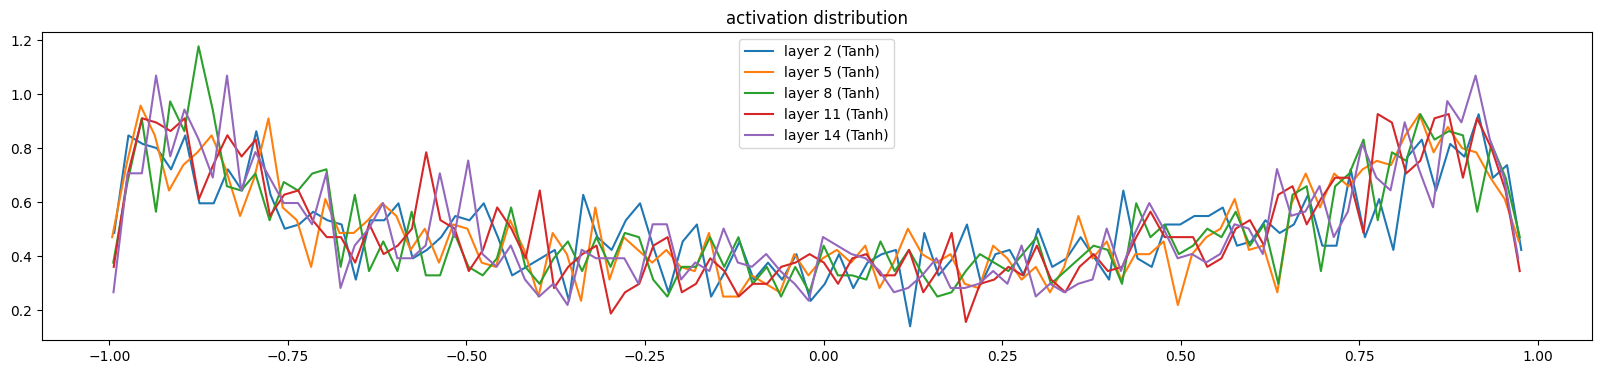

In [30]:
# Plot histogram of layer activations
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the last output layer
  if isinstance(layer, Tanh):
    t = layer.out
    print("layer %d (%10s): mean %+.2f, std %.2f, saturated: %.2f%%" % (i, layer.__class__.__name__, t.mean(), t.std(), (t.abs() > 0.97).float().mean()*100))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title('activation distribution')

Saturation represents the percentage of data that are at the ends of the distribution i.e absolute value >0.97. As mentioned above at these values, the gradients will fail to propogate through the neuron causing the vanishing gradient problem. Therefore maintaining a low saturation value is important

layer 2 (      Tanh): mean +0.000000, std 3.682954e-03
layer 5 (      Tanh): mean -0.000000, std 3.262608e-03
layer 8 (      Tanh): mean +0.000000, std 2.973729e-03
layer 11 (      Tanh): mean -0.000000, std 2.741110e-03
layer 14 (      Tanh): mean +0.000000, std 2.584293e-03


Text(0.5, 1.0, 'gradient distribution')

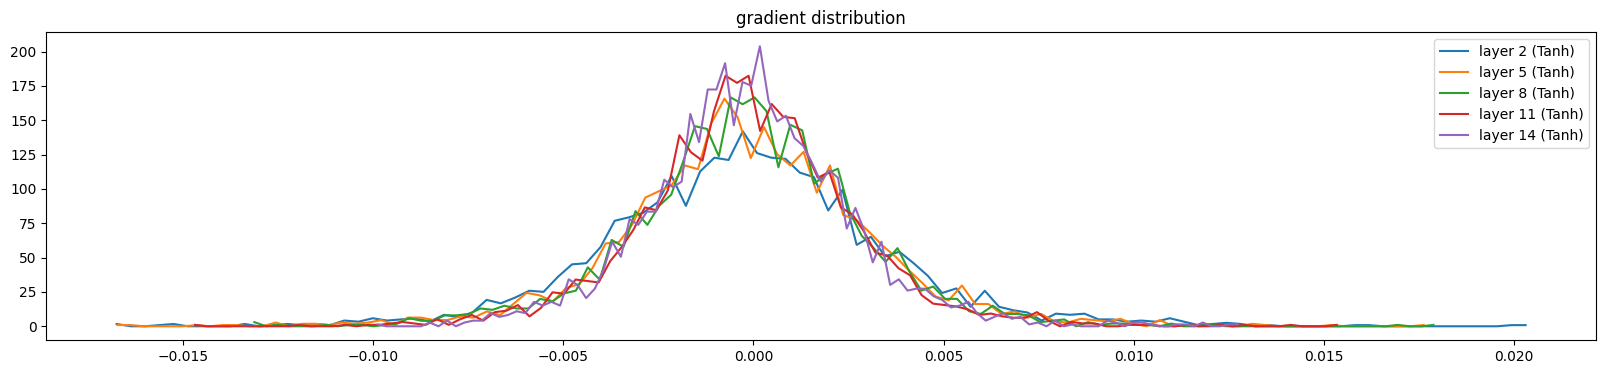

In [31]:
# Plot histogram of layer gradients
plt.figure(figsize=(20, 4))
legends = []

for i, layer in enumerate(layers[:-1]): # exclude the last output layer
  if isinstance(layer, Tanh):
    t = layer.out.grad
    print("layer %d (%10s): mean %+f, std %e" % (i, layer.__class__.__name__, t.mean(), t.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title('gradient distribution')

Gradients should not shrink (converge) towards 0

weight   (27, 10) | mean +0.000000 | std 1.019885e-02 | grad:data ratio 1.018846e-02
weight  (30, 100) | mean +0.000092 | std 8.238429e-03 | grad:data ratio 2.635839e-02
weight (100, 100) | mean +0.000031 | std 7.318111e-03 | grad:data ratio 4.377144e-02
weight (100, 100) | mean -0.000019 | std 6.662022e-03 | grad:data ratio 3.949895e-02
weight (100, 100) | mean -0.000019 | std 5.821513e-03 | grad:data ratio 3.468159e-02
weight (100, 100) | mean +0.000053 | std 5.445295e-03 | grad:data ratio 3.243367e-02
weight  (100, 27) | mean -0.000165 | std 1.046844e-02 | grad:data ratio 6.281264e-02


Text(0.5, 1.0, 'weight distribution')

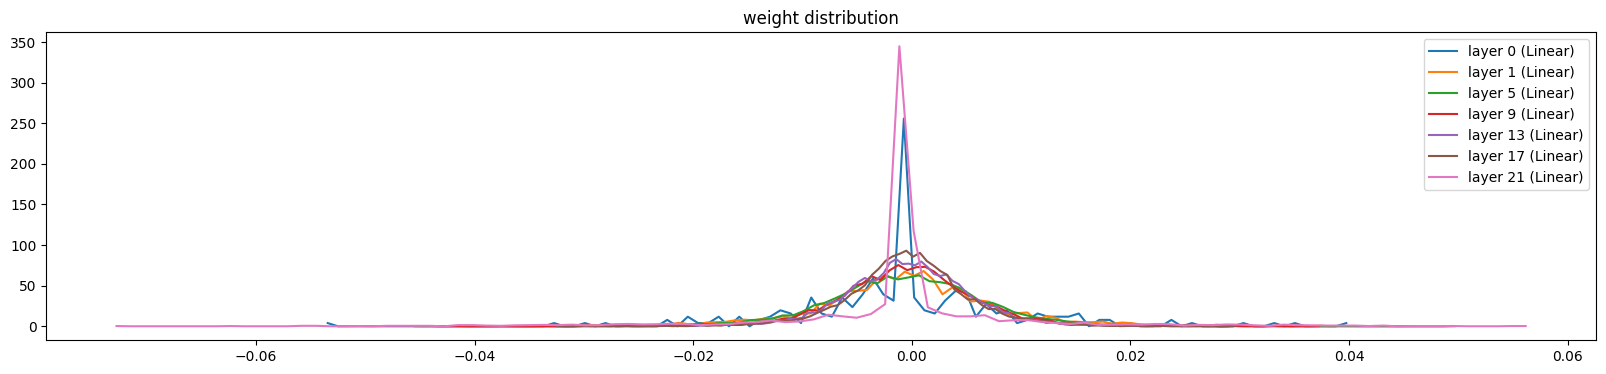

In [32]:
# Plot histogram of weights
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  t = p.grad
  if p.ndim == 2:
    print("weight %10s | mean %+f | std %e | grad:data ratio %e" % (tuple(p.shape), t.mean(), t.std(), t.std() / p.std()))
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
    legends.append(f"layer {i} ({layer.__class__.__name__})")

plt.legend(legends)
plt.title('weight distribution')

The gradient-data ratio represents how large the gradient is compared to the current set of weights, we want these to be roughly the same across all layers. If the gradient is too large, means a layers weights are being updated too quickly, conversely, if it's too small, the layer is not being updated as much.

The graph usually starts to even out with more iterations run. If problem still persists, check how the gradients and weights are changing

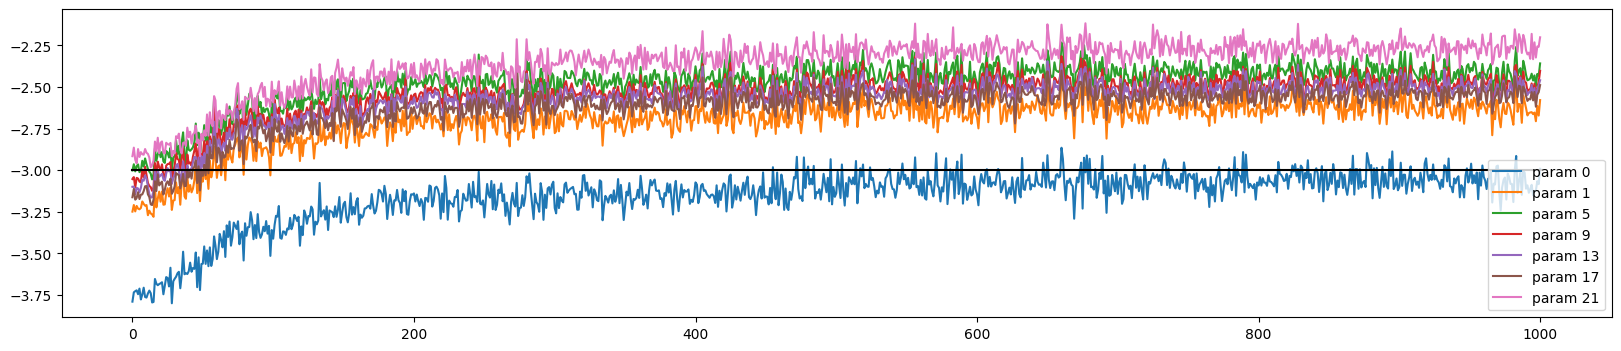

In [33]:
plt.figure(figsize=(20, 4))
legends = []
for i, p in enumerate(parameters):
  if p.ndim == 2:
    plt.plot([ud[j][i] for j in range(len(ud))])
    legends.append('param %d' % i)

plt.plot([0, len(ud)], [-3, -3], 'k')
plt.legend(legends)

Values should all be close to the black line which indicates that ratios are ~1e-3 to the data. This plot helps to calibrate the _learning rate_, because a small learning rate would have the gradients be much below the line

The last layer is an exception since we are artificially scaling it for the softmax layer

In [ ]:
%watermark